# Goal : predict total hourly charging demand (kwh) across all stations

In [100]:
# pulling the parquets from s3 and loading into pandas dataframes
import pandas as pd
storage_options = {
    "client_kwargs": {"endpoint_url": "http://localhost:4566"},"key": "test", "secret": "test"  }
df = pd.read_parquet('s3://ev-data', engine='pyarrow', storage_options=storage_options)
df.head()

,session_id,garage_id,user_id,user_type,shared_id,start_plugin,start_plugin_hour,end_plugout,end_plugout_hour,el_kwh,duration_hours,month_plugin,weekdays_plugin,plugin_category,duration_category,year,month
0,1,AdO3,AdO3-4,Private,None,2018-12-21 10:20:00,10,2018-12-21 10:23:00,10.0,0.30,0.050000,Dec,Friday,late morning (9-12),Less than 3 hours,2018,12
1,2,AdO3,AdO3-4,Private,None,2018-12-21 10:24:00,10,2018-12-21 10:32:00,10.0,0.87,0.136667,Dec,Friday,late morning (9-12),Less than 3 hours,2018,12
2,3,AdO3,AdO3-4,Private,None,2018-12-21 11:33:00,11,2018-12-21 19:46:00,19.0,29.87,8.216389,Dec,Friday,late morning (9-12),Between 6 and 9 hours,2018,12
3,4,AdO3,AdO3-2,Private,None,2018-12-22 16:15:00,16,2018-12-23 16:40:00,16.0,15.56,24.419722,Dec,Saturday,late afternoon (15-18),More than 18 hours,2018,12
4,5,AdO3,AdO3-2,Private,None,2018-12-24 22:03:00,22,2018-12-24 23:02:00,23.0,3.62,0.970556,Dec,Monday,late evening (21-midnight),Less than 3 hours,2018,12


In [101]:
print(df.info())
print('==============================')
print(df.describe())
print('==============================')
print(df.isna().sum())
print('==============================')
print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6844 entries, 0 to 6843
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   session_id         6844 non-null   int64         
 1   garage_id          6844 non-null   object        
 2   user_id            6844 non-null   object        
 3   user_type          6844 non-null   object        
 4   shared_id          1402 non-null   object        
 5   start_plugin       6844 non-null   datetime64[ns]
 6   start_plugin_hour  6844 non-null   int64         
 7   end_plugout        6844 non-null   datetime64[ns]
 8   end_plugout_hour   6844 non-null   float64       
 9   el_kwh             6844 non-null   float64       
 10  duration_hours     6844 non-null   float64       
 11  month_plugin       6844 non-null   object        
 12  weekdays_plugin    6844 non-null   object        
 13  plugin_category    6844 non-null   object        
 14  duration

In [102]:
category_columns = [
    'user_type', 'shared_id', 'month_plugin', 'weekdays_plugin', 'plugin_category', 'duration_category'
]
for col in category_columns:
    df[col] = df[col].astype('category')
df['end_plugout_hour'] = df['end_plugout_hour'].astype('int64')
print(df.dtypes)

session_id                    int64
garage_id                    object
user_id                      object
user_type                  category
shared_id                  category
start_plugin         datetime64[ns]
start_plugin_hour             int64
end_plugout          datetime64[ns]
end_plugout_hour              int64
el_kwh                      float64
duration_hours              float64
month_plugin               category
weekdays_plugin            category
plugin_category            category
duration_category          category
year                       category
month                      category
dtype: object


In [103]:
#verifying start_plugin_hour
import numpy as np
df['hour'] = df['start_plugin'].dt.hour


df['start_plugin_hour'] = np.where(
    df['start_plugin_hour'] != df['hour'],
    df['hour'],                             
    df['start_plugin_hour']                 
)

In [104]:
print("Mismatches left:", (df['start_plugin_hour'] != df['hour']).sum())
df=df.drop(columns='hour')

Mismatches left: 0


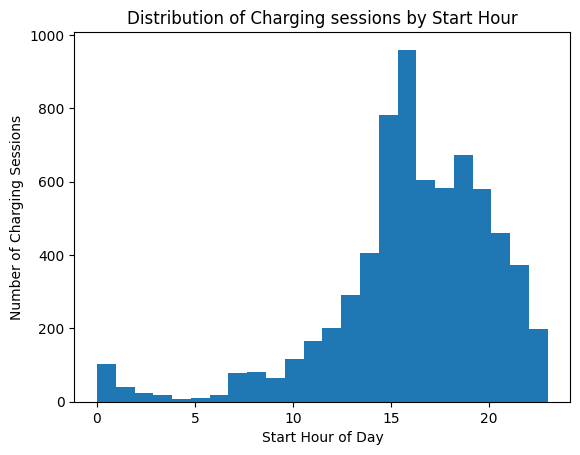

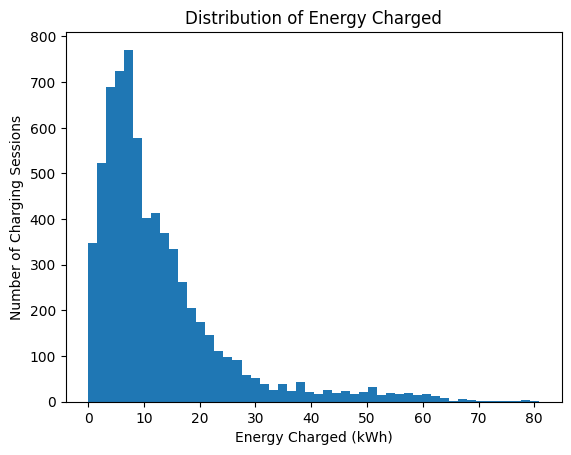

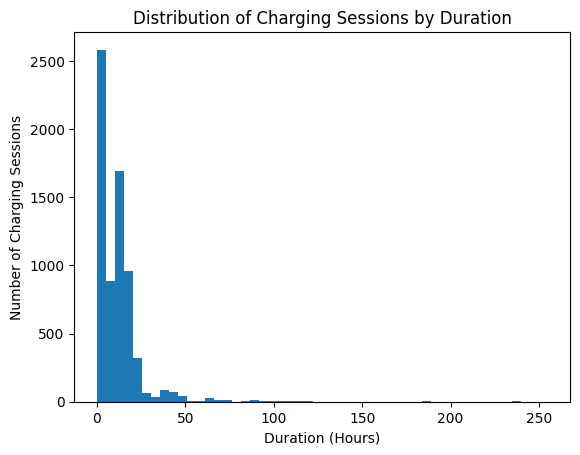

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.hist(df['start_plugin_hour'], bins=24)
plt.xlabel('Start Hour of Day')
plt.ylabel('Number of Charging Sessions')
plt.title('Distribution of Charging sessions by Start Hour')
plt.show()
plt.hist(df['el_kwh'], bins=50)
plt.xlabel('Energy Charged (kWh)')
plt.ylabel('Number of Charging Sessions')
plt.title('Distribution of Energy Charged')
plt.show()
plt.hist(df['duration_hours'], bins=50)
plt.xlabel('Duration (Hours)')
plt.ylabel('Number of Charging Sessions')
plt.title('Distribution of Charging Sessions by Duration')
plt.show()

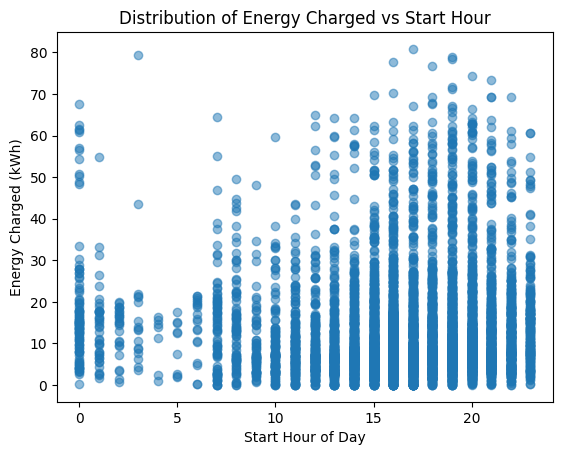

In [107]:
import matplotlib.pyplot as plt
plt.scatter(df['start_plugin_hour'], df['el_kwh'], alpha=0.5)
plt.xlabel('Start Hour of Day')
plt.ylabel('Energy Charged (kWh)')
plt.title('Distribution of Energy Charged vs Start Hour')
plt.show()

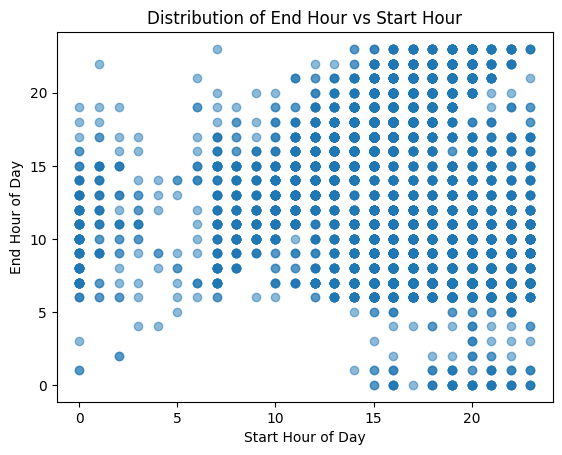

In [108]:
import matplotlib.pyplot as plt
plt.scatter(df['start_plugin_hour'], df['end_plugout_hour'], alpha=0.5)
plt.xlabel('Start Hour of Day')
plt.ylabel('End Hour of Day')
plt.title('Distribution of End Hour vs Start Hour')
plt.show()

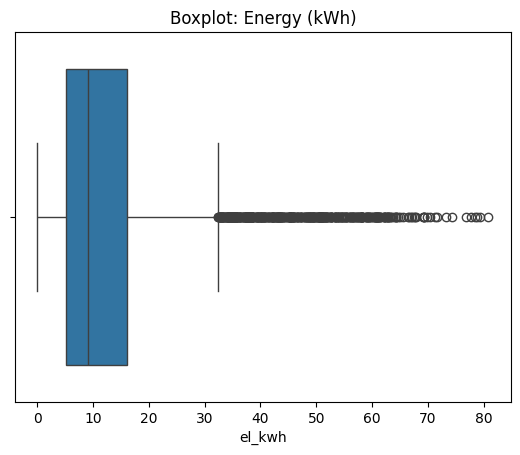

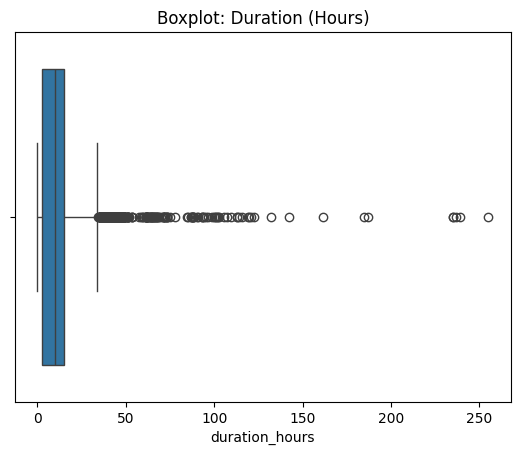

In [109]:
sns.boxplot(x=df['el_kwh'].dropna())
plt.title('Boxplot: Energy (kWh)')
plt.show()
sns.boxplot(x=df['duration_hours'].dropna())
plt.title('Boxplot: Duration (Hours)')
plt.show()

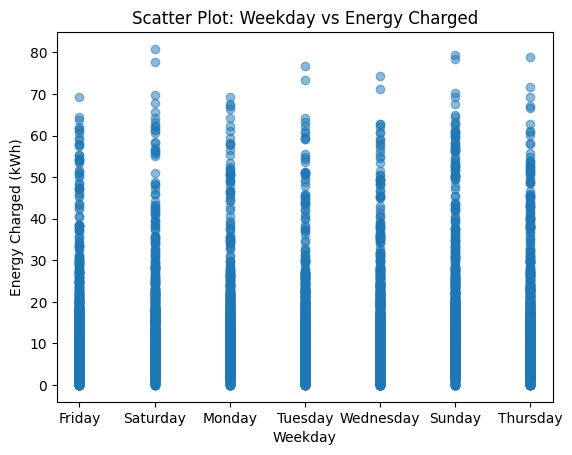

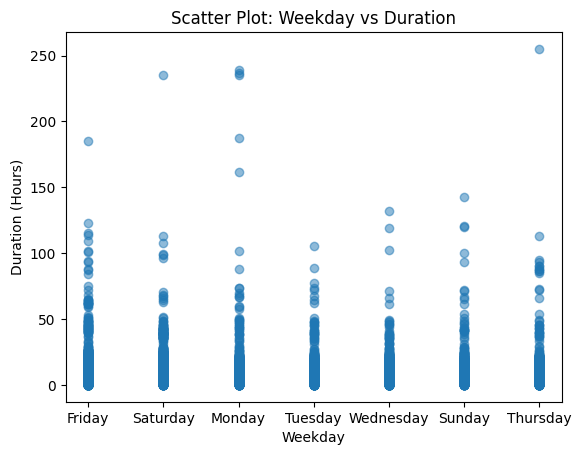

In [110]:
plt.scatter(df['weekdays_plugin'], df['el_kwh'], alpha=0.5)
plt.xlabel('Weekday')
plt.ylabel('Energy Charged (kWh)')
plt.title('Scatter Plot: Weekday vs Energy Charged')
plt.show()
plt.scatter(df['weekdays_plugin'], df['duration_hours'], alpha=0.5)
plt.xlabel('Weekday')
plt.ylabel('Duration (Hours)')
plt.title('Scatter Plot: Weekday vs Duration')
plt.show()

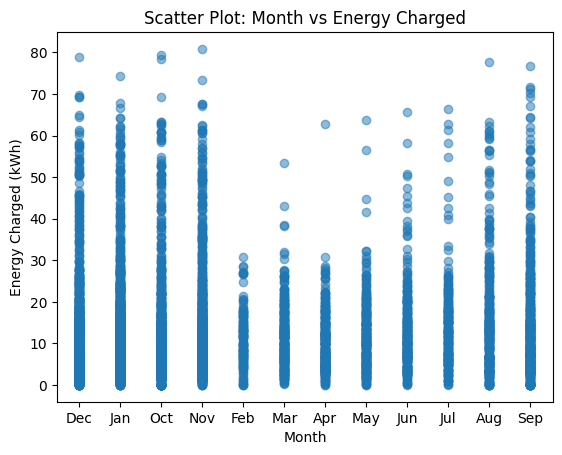

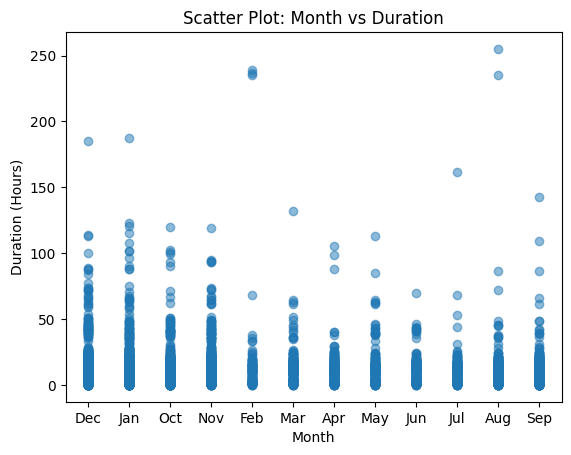

In [111]:
plt.scatter(df['month_plugin'], df['el_kwh'], alpha=0.5)
plt.xlabel('Month')
plt.ylabel('Energy Charged (kWh)')
plt.title('Scatter Plot: Month vs Energy Charged')
plt.show()
plt.scatter(df['month_plugin'], df['duration_hours'], alpha=0.5)
plt.xlabel('Month')
plt.ylabel('Duration (Hours)')
plt.title('Scatter Plot: Month vs Duration')
plt.show()

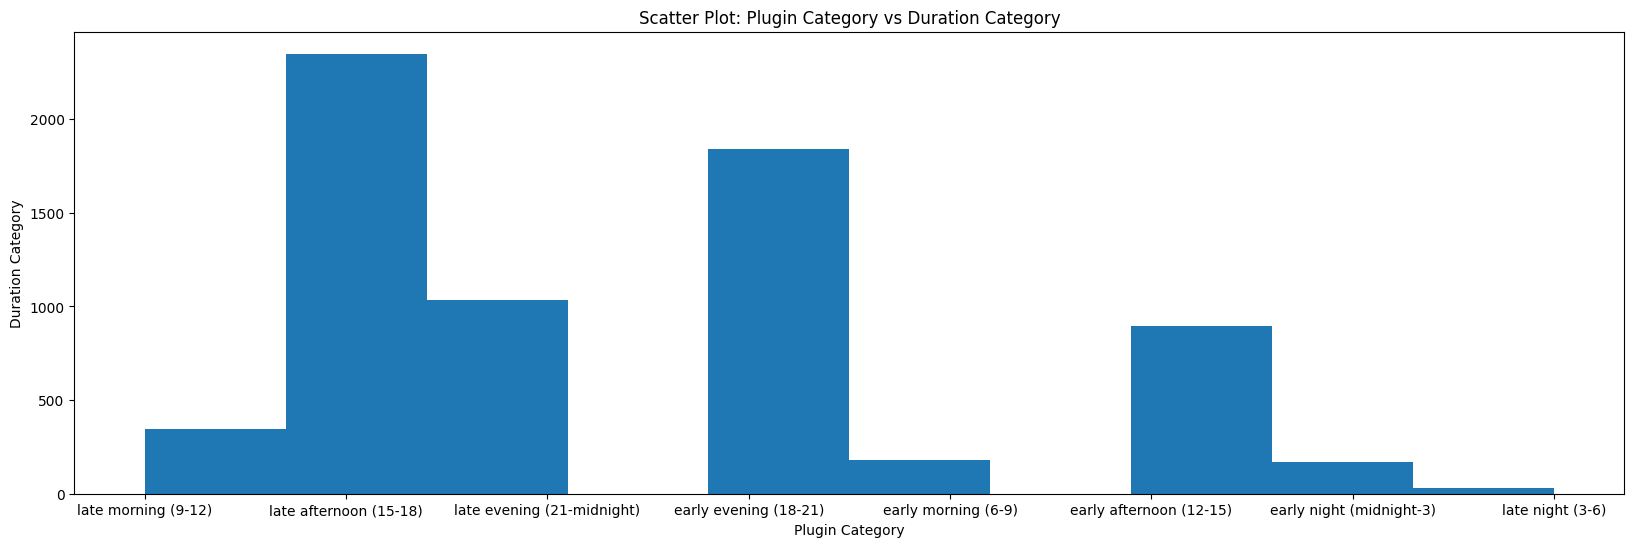

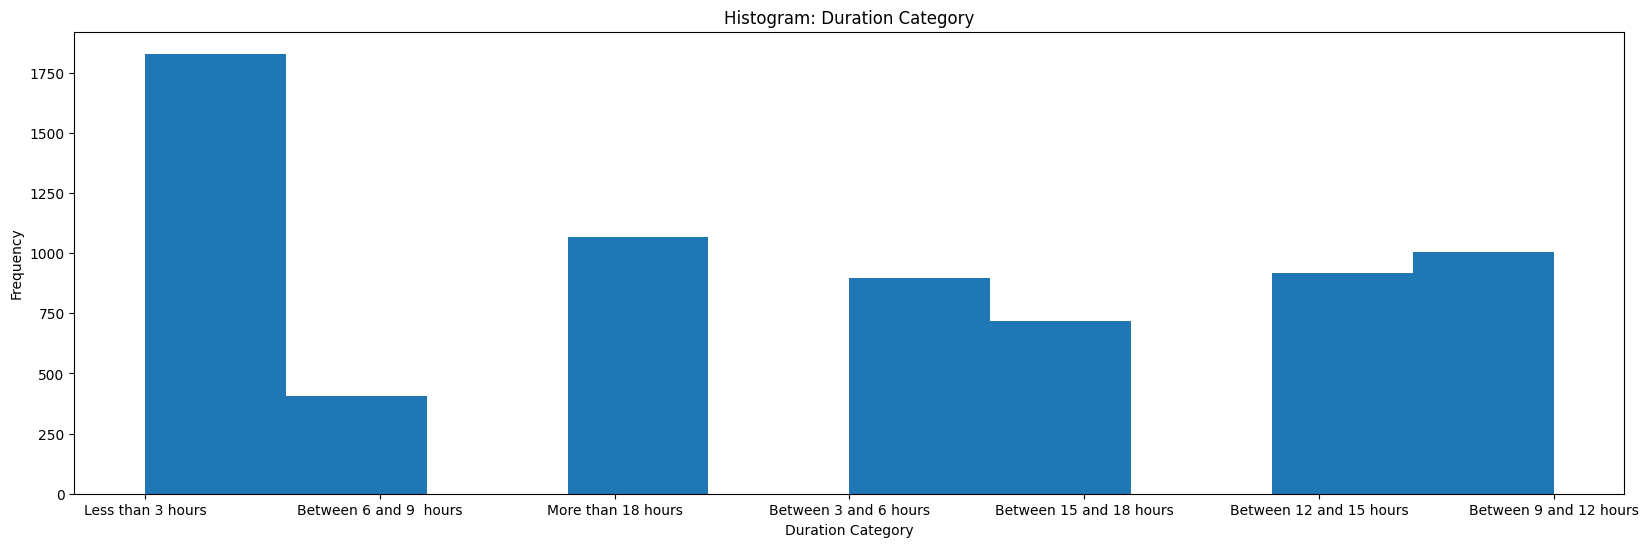

In [112]:
plt.figure(figsize=(20,6))
plt.hist(df['plugin_category'])
plt.xlabel('Plugin Category')
plt.ylabel('Duration Category')
plt.title('Scatter Plot: Plugin Category vs Duration Category')
plt.show()
plt.figure(figsize=(20,6))
plt.hist(df['duration_category'])
plt.xlabel('Duration Category')
plt.ylabel('Frequency')
plt.title('Histogram: Duration Category')
plt.show()
